In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.utils
import matplotlib.pyplot as plt
import seaborn as sns

# Split the Data

In [2]:
# Directories containing preprocessed images
save_directory_real = '../data/interim/face_processed/real'
save_directory_fake = '../data/interim/face_processed/fake'

# Function to create a DataFrame with image paths and labels
# Changing labelling to be 1 if fake and 0 if real
def create_image_label_df(real_dir, fake_dir):
    real_images = [(os.path.join(real_dir, f), 0) for f in os.listdir(real_dir) if os.path.isfile(os.path.join(real_dir, f))]
    fake_images = [(os.path.join(fake_dir, f), 1) for f in os.listdir(fake_dir) if os.path.isfile(os.path.join(fake_dir, f))]
    
    # Combine real and fake images into one DataFrame
    df = pd.DataFrame(real_images + fake_images, columns=['image_path', 'label'])
    return df

# Create the DataFrame
images_df = create_image_label_df(save_directory_real, save_directory_fake)

In [3]:
# Splitting the data into features and target arrays
X = images_df['image_path'].values
y = images_df['label'].values

# First split to separate out the test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

# Second split to separate out the training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp, shuffle=True)  # 0.25 x 0.8 = 0.2

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Testing set size: {len(X_test)}")

'''
Training Set: 60% of the original dataset.
Validation Set: 20% of the original dataset.
Testing Set: 20% of the original dataset.
'''

Training set size: 2400
Validation set size: 800
Testing set size: 800


'\nTraining Set: 60% of the original dataset.\nValidation Set: 20% of the original dataset.\nTesting Set: 20% of the original dataset.\n'

In [4]:
training = pd.DataFrame({'image_path': X_train, 'label': y_train.astype(str)})
validating = pd.DataFrame({'image_path': X_val, 'label': y_val.astype(str)})
testing = pd.DataFrame({'image_path': X_test, 'label': y_test.astype(str)})

# Data augmentation with data generators

# Modelling

- Pre-trained Models (VGG16) - using data generator on all 3 datasets

In [5]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_data = train_datagen.flow_from_dataframe(training, x_col='image_path',
                                               y_col='label', 
                                               class_mode='binary',
                                               batch_size=32, 
                                               target_size=(128,128),
                                               shuffle=True)

val_data = train_datagen.flow_from_dataframe(validating, x_col='image_path',
                                               y_col='label', 
                                               class_mode='binary',
                                               batch_size=32, 
                                               target_size=(128,128),
                                               shuffle=True)

test_data = train_datagen.flow_from_dataframe(testing, x_col='image_path',
                                               y_col='label', 
                                               class_mode='binary',
                                               batch_size=32, 
                                               target_size=(128,128),
                                               shuffle=True)

Found 2400 validated image filenames belonging to 2 classes.


Found 800 validated image filenames belonging to 2 classes.
Found 800 validated image filenames belonging to 2 classes.


In [6]:
tf_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freezing the CNN layers
for layer in tf_model.layers:
    layer.trainable = False

model = Sequential([
    tf_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy', 
              metrics=['accuracy'])
model.summary()

callbacks_list = [
    EarlyStopping(patience=5,
                  restore_best_weights=True),
    ReduceLROnPlateau(patience=2,
                      factor=0.5,
                      min_lr = 0.00001,
                      verbose = 1)
]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [7]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
mod_hist = model.fit(train_data,
                     steps_per_epoch=len(train_data), 
                     epochs=10,
                     validation_data=val_data,
                     validation_steps=len(val_data),
                     callbacks = callbacks_list)

Epoch 1/10


2024-04-11 14:24:17.651928: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


75/75 [==============================] - 754s 10s/step - loss: 4.0774 - accuracy: 0.5883 - val_loss: 0.6944 - val_accuracy: 0.6463 - lr: 0.0010
Epoch 2/10
75/75 [==============================] - 800s 11s/step - loss: 0.7012 - accuracy: 0.6133 - val_loss: 0.7159 - val_accuracy: 0.6862 - lr: 0.0010
Epoch 3/10
75/75 [==============================] - 628s 8s/step - loss: 0.6793 - accuracy: 0.6504 - val_loss: 0.6252 - val_accuracy: 0.6913 - lr: 0.0010
Epoch 4/10
75/75 [==============================] - 756s 10s/step - loss: 0.6345 - accuracy: 0.6758 - val_loss: 0.6160 - val_accuracy: 0.6700 - lr: 0.0010
Epoch 5/10
75/75 [==============================] - ETA: 0s - loss: 0.6016 - accuracy: 0.6796 

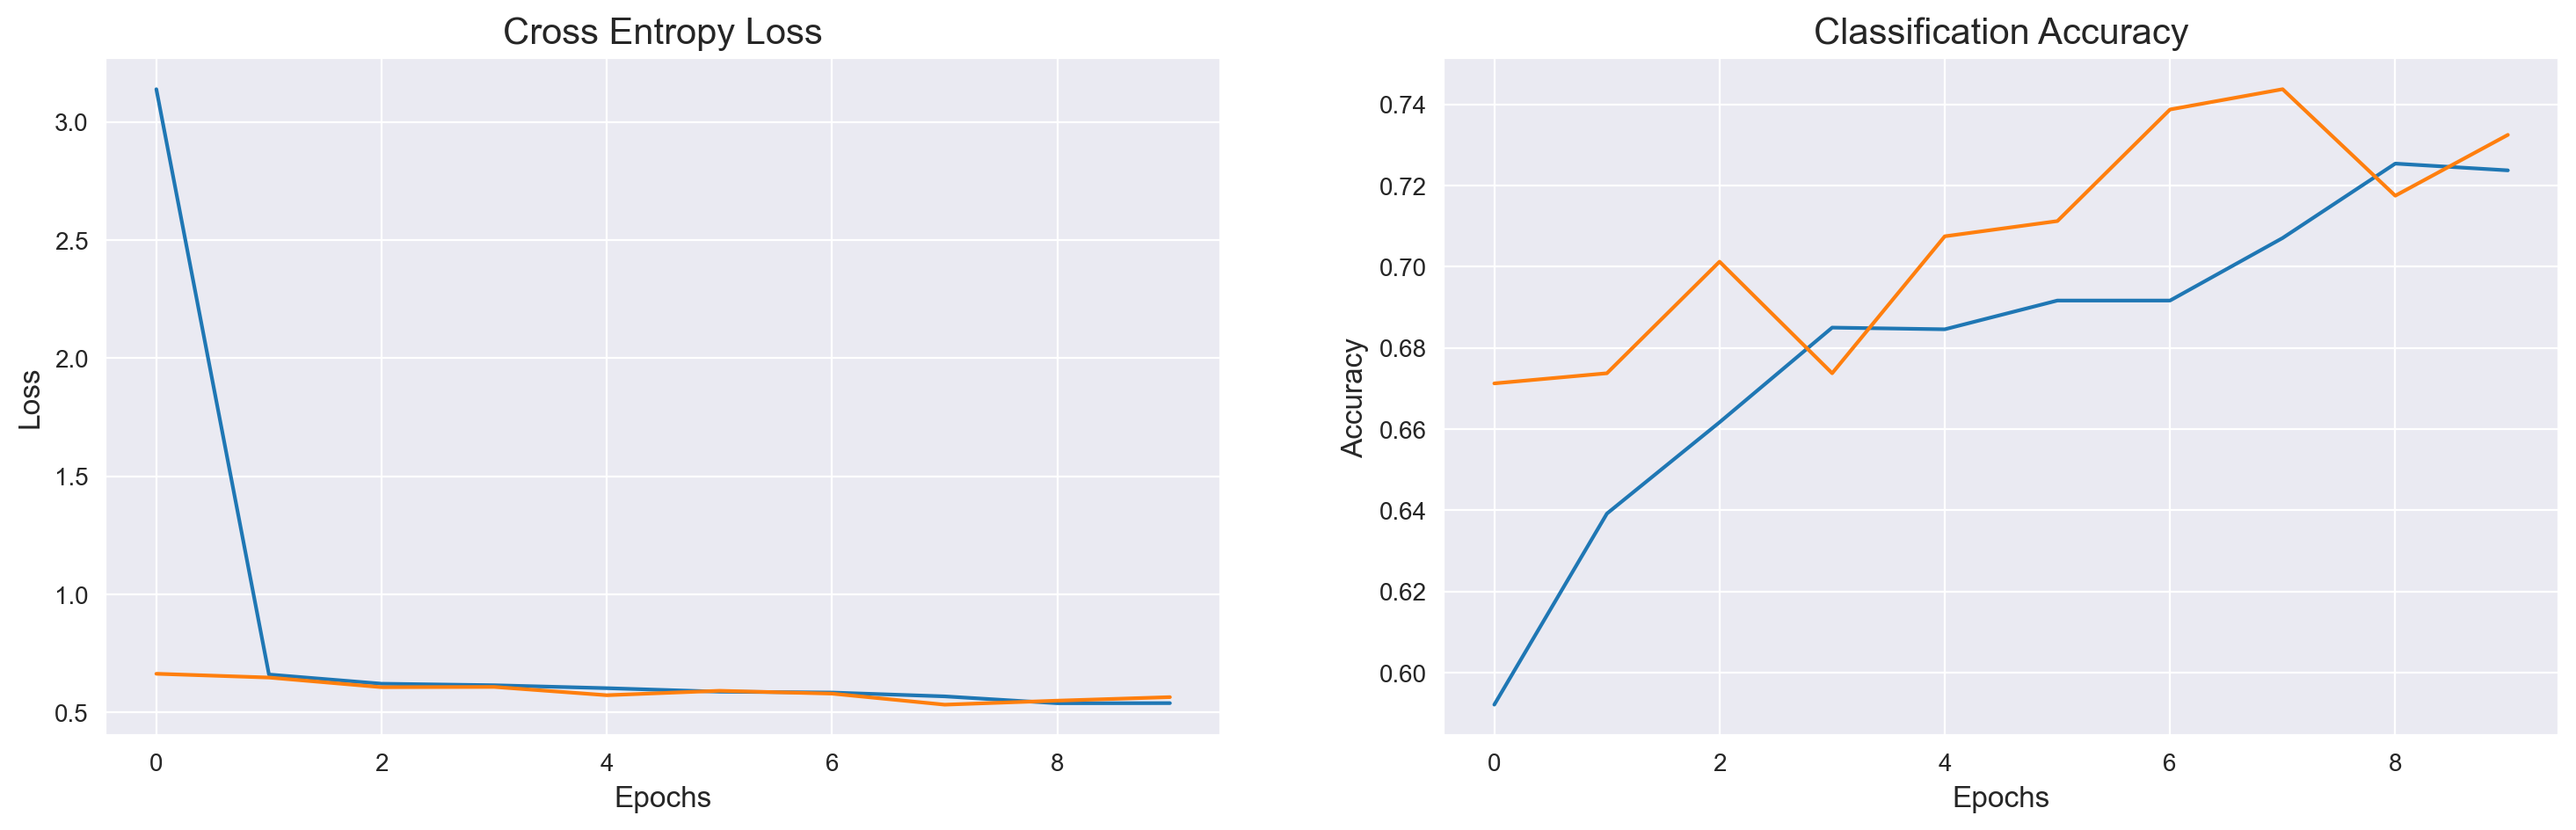

In [ ]:
# plots for accuracy and Loss with epochs
error = pd.DataFrame(mod_hist.history)

plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(error['loss'])
plt.plot(error['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(error['accuracy'])
plt.plot(error['val_accuracy'])

plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_data, steps=len(test_data))
print(accuracy)

25/25 [==============================] - 55s 2s/step - loss: 0.5709 - accuracy: 0.7237
0.7237499952316284


In [ ]:
#Classes: fake == 1, real==0
predictions = model.predict(test_data)
y_probab = predictions[:, 0]  # Assuming predictions.shape = (n_samples, 1)
print(y_probab)

25/25 [==============================] - 62s 2s/step
[4.67057168e-01 7.57274151e-01 1.42059892e-01 3.58267725e-01
 3.58863622e-01 5.24317682e-01 2.67377704e-01 8.95723104e-01
 2.91219682e-01 3.96678030e-01 2.94507653e-01 6.45072639e-01
 7.13407546e-02 5.88050544e-01 6.18224800e-01 4.37102318e-01
 7.46300340e-01 5.80179453e-01 3.58044535e-01 7.74741292e-01
 5.23673177e-01 6.06108427e-01 4.84679312e-01 4.86191779e-01
 1.88706353e-01 3.70577335e-01 3.40809703e-01 4.38751549e-01
 2.20413551e-01 6.55407786e-01 8.55957448e-01 2.14878857e-01
 3.36723655e-01 5.54436743e-01 4.45741355e-01 4.24579173e-01
 6.55519187e-01 8.62833202e-01 7.41015971e-02 7.27056980e-01
 2.31889948e-01 1.43411988e-03 4.71190542e-01 8.34808111e-01
 3.65238547e-01 5.33508182e-01 8.73967409e-01 6.57376707e-01
 7.23328471e-01 6.17906570e-01 4.40293074e-01 4.05776888e-01
 2.93090194e-01 7.00052381e-01 5.60765684e-01 7.05622256e-01
 4.04338360e-01 1.34662256e-01 7.12914705e-01 5.42768776e-01
 1.26747444e-01 8.28454494e-01 3